# EEGManyPipelines ERP inferences

## Imports

In [1]:
import easyEEG
import mne
from mne import find_events, Epochs, pick_types, read_evokeds
import pandas as pd
import numpy as np

import os
import re
import glob
import os
import ast

EasyEEG loaded.


## Parameters

In [2]:
tmin, tmax = -0.1, 0.6  # Start and end of the segments
signal_frequency = 256
ERROR = 0
CORRECT = 1
random_state = 0

In [3]:
channels_order_list = [
    "Fp1",
    "AF7",
    "AF3",
    "F1",
    "F3",
    "F5",
    "F7",
    "FT7",
    "FC5",
    "FC3",
    "FC1",
    "C1",
    "C3",
    "C5",
    "T7",
    "TP7",
    "CP5",
    "CP3",
    "CP1",
    "P1",
    "P3",
    "P5",
    "P7",
    "P9",
    "PO7",
    "PO3",
    "O1",
    "Iz",
    "Oz",
    "POz",
    "Pz",
    "CPz",
    "Fpz",
    "Fp2",
    "AF8",
    "AF4",
    "AFz",
    "Fz",
    "F2",
    "F4",
    "F6",
    "F8",
    "FT8",
    "FC6",
    "FC4",
    "FC2",
    "FCz",
    "Cz",
    "C2",
    "C4",
    "C6",
    "T8",
    "TP8",
    "CP6",
    "CP4",
    "CP2",
    "P2",
    "P4",
    "P6",
    "P8",
    "P10",
    "PO8",
    "PO4",
    "O2",
]

channels_dict = dict(zip(channels_order_list, np.arange(1, 64, 1)))

## Load data

In [4]:
dir_path = os.path.dirname(os.path.abspath(""))

In [5]:
def load_epochs_from_file(file):
    """Load epochs from a header file.

    Args:
        file: path to a header file (.vhdr)

    Returns:
        mne Epochs

    """
    # Import the BrainVision data into an MNE Raw object
    raw = mne.io.read_raw_brainvision(file)

    # Construct annotation filename
    annot_file = file[:-4] + "vmrk"

    # Read in the event information as MNE annotations
    annotations = mne.read_annotations(annot_file)

    # Add the annotations to our raw object so we can use them with the data
    raw.set_annotations(annotations)

    # Map with response markers only
    event_dict = {
        "Stimulus/RE*ex*1_n*1_c_1*R*FB": 10004,
        "Stimulus/RE*ex*1_n*1_c_1*R*FG": 10005,
        "Stimulus/RE*ex*1_n*1_c_2*R": 10006,
        "Stimulus/RE*ex*1_n*2_c_1*R": 10007,
        "Stimulus/RE*ex*2_n*1_c_1*R": 10008,
        "Stimulus/RE*ex*2_n*2_c_1*R*FB": 10009,
        "Stimulus/RE*ex*2_n*2_c_1*R*FG": 10010,
        "Stimulus/RE*ex*2_n*2_c_2*R": 10011,
    }

    # Map for merged correct/error response markers
    merged_event_dict = {"correct_response": 0, "error_response": 1}

    # Reconstruct the original events from Raw object
    events, event_ids = mne.events_from_annotations(raw, event_id=event_dict)

    # Merge correct/error response events
    merged_events = mne.merge_events(
        events,
        [10004, 10005, 10009, 10010],
        merged_event_dict["correct_response"],
        replace_events=True,
    )
    merged_events = mne.merge_events(
        merged_events,
        [10006, 10007, 10008, 10011],
        merged_event_dict["error_response"],
        replace_events=True,
    )

    epochs = []

    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=merged_events,
        event_id=merged_event_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=True,
        preload=True,
    )
        
    if ((epochs['correct_response']._data.shape[0] > 2) and (epochs['error_response']._data.shape[0] > 2)):
        epochs = epochs.equalize_event_counts(['correct_response', 'error_response'])[0]

        participant_id = re.match(r".*_(\w+).*", file).group(1)

        print(epochs)


        epochs.save(f'data_eegPip/{participant_id}-epo.fif', overwrite=True)
        print(f' EXTRACTED {participant_id}\n')

In [6]:
def create_df_data():
    dir_path = os.path.dirname(os.path.abspath(""))
    header_files_glob = os.path.join(dir_path, "rumination_project/erpinator/data/responses/*.vhdr")
    header_files = glob.glob(header_files_glob)

    # header_files = sorted(header_files)
    
    for file in header_files:
        #  load eeg data for given participant
        # print(file)
        load_epochs_from_file(file)

In [7]:
# load data and save as .fif files

# create_df_data()

## Save data in EasyEEG format

In [ ]:
# fif_files_glob = os.path.join(os.path.abspath(""), "data_eegPip/*.fif")
# print(fif_files_glob)
# fif_files_list = glob.glob(fif_files_glob)

# epochs = easyEEG.io.load_mne_fif(fif_files_list)
# epochs.save('data_eegPip/data.h5')

## Load data in EasyEEG format

In [2]:
epochs = easyEEG.io.load_epochs('data_eegPip/data.h5') # the file is 6GB, please contach us if you need it

reading 1
reading 10
reading 100
reading 101
reading 102
reading 103
reading 104
reading 105
reading 106
reading 107
reading 108
reading 109
reading 11
reading 110
reading 111
reading 112
reading 113
reading 114
reading 115
reading 116
reading 117
reading 118
reading 119
reading 12
reading 120
reading 121
reading 122
reading 123
reading 124
reading 125
reading 126
reading 127
reading 128
reading 129
reading 13
reading 130
reading 131
reading 132
reading 133
reading 134
reading 135
reading 136
reading 137
reading 138
reading 139
reading 14
reading 140
reading 141
reading 142
reading 143
reading 144
reading 145
reading 146
reading 147
reading 148
reading 149
reading 15
reading 150
reading 16
reading 17
reading 18
reading 19
reading 2
reading 20
reading 21
reading 22
reading 23
reading 24
reading 25
reading 26
reading 27
reading 28
reading 29
reading 3
reading 30
reading 31
reading 32
reading 33
reading 34
reading 35
reading 36
reading 37
reading 38
reading 39
reading 4
reading 40
reading

In [5]:
# epochs.info

## Topographic differences

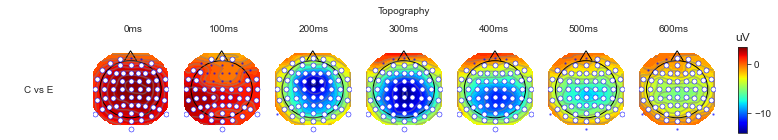

<Figure size 432x288 with 0 Axes>

In [6]:
script = {'conditions': 'C vs E:correct_response&error_response',
         'timepoints': '-50~600'}
e = epochs.extract(script)

topo = e.topography(win_size='100ms')
topo.plot()

100% 30/30 [00:00<00:00, 129.70it/s]


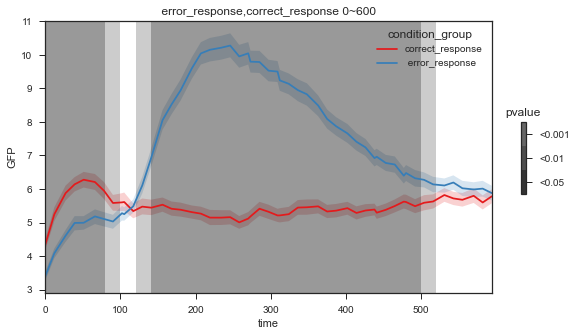

<Figure size 432x288 with 0 Axes>

In [4]:
scripts = [{'conditions': 'correct_response, error_response',
           'timepoints': '0~600'}]

for idx,script in enumerate(scripts):
    gfp = epochs.extract(script).GFP(compare=True)
    gfp.default_plot_params['style']='ticks' # remove the backgroud color for paper publication
    gfp.plot()